In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [20]:
#!cp /content/drive/MyDrive/Colab\ Notebooks/data/* .

df = pd.read_table('video_titles.txt', sep='\n', names=['vidtitle'])
df.insert(0, 'category', ['video']*df.size)
cnt1 = df.category.size

toappend = pd.read_table('music_titles.txt', sep='\n', names=['vidtitle'])
toappend.insert(0, 'category', ['music']*toappend.size)

df = df.append(toappend)

cnt2 = df.category.size

toappend = pd.read_table('podcast_titles.txt', sep='\n', names=['vidtitle'])
toappend.insert(0, 'category', ['podcast']*toappend.size)

df = df.append(toappend)

cnt3 = df.category.size

df

,category,vidtitle
0,video,15000 Odběratelů & soutěž o BeoPlay H8
1,video,"262 dnů Carnivore diet. Výsledky testů, aktuá..."
2,video,"27"" iMac 2020. Návrat krále? [4K]"
3,video,Apple Watch Series 5 - UNBOXING A PRVNÍ POCIT...
4,video,Audi e-tron ve španělské Marbelle a setkání s...
...,...,...
1931,podcast,"Za ""za všechno může Kalousek"" může Babiš, říká..."
1932,podcast,Zdeněk Hřib: Češi mají v povaze obcházet předp...
1933,podcast,"Zdeněk Pohlreich: Pro KFC mám slabost, ale kuř..."
1934,podcast,Zeman jde přes mrtvoly. Jeho poradci spoluprac...


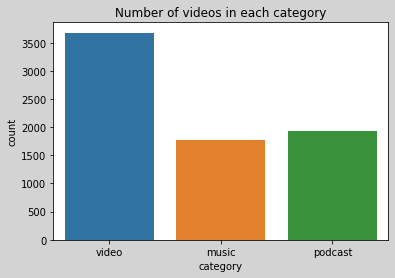

In [21]:
plt.figure(facecolor='lightgrey')
plt.title('Number of videos in each category')

sns.countplot(x=df.category)

In [22]:
for i in range(cnt1):
  df.category.iloc[i] = 0
for i in range(cnt1,cnt2):
  df.category.iloc[i] = 1
for i in range(cnt2,cnt3):
  df.category.iloc[i] = 2


X = df.vidtitle
Y = np.array(df.category)
Y = Y.reshape(-1,1)

encoder = ColumnTransformer(
    [('category', OneHotEncoder(dtype='int'), [0])],
    remainder = 'passthrough'
)
Y = encoder.fit_transform(Y)

In [23]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [24]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [25]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(512,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [26]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
FC1 (Dense)                  (None, 512)               66048     
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 1539

In [27]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=8,
          validation_split=0.2)
          #,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/8
40/40 [==============================] - 23s 532ms/step - loss: 0.6169 - accuracy: 0.5147 - val_loss: 0.3361 - val_accuracy: 0.9077
Epoch 2/8
40/40 [==============================] - 21s 531ms/step - loss: 0.2166 - accuracy: 0.9084 - val_loss: 0.1918 - val_accuracy: 0.9037
Epoch 3/8
40/40 [==============================] - 21s 531ms/step - loss: 0.0897 - accuracy: 0.9525 - val_loss: 0.0764 - val_accuracy: 0.9578
Epoch 4/8
40/40 [==============================] - 21s 534ms/step - loss: 0.2220 - accuracy: 0.9347 - val_loss: 0.0715 - val_accuracy: 0.9594
Epoch 5/8
40/40 [==============================] - 21s 534ms/step - loss: 0.0563 - accuracy: 0.9678 - val_loss: 0.0691 - val_accuracy: 0.9602
Epoch 6/8
40/40 [==============================] - 21s 531ms/step - loss: 0.0437 - accuracy: 0.9734 - val_loss: 0.0947 - val_accuracy: 0.9467
Epoch 7/8
40/40 [==============================] - 21s 532ms/step - loss: 0.0422 - accuracy: 0.9718 - val_loss: 0.0707 - val_accuracy: 0.9602
Epoch 

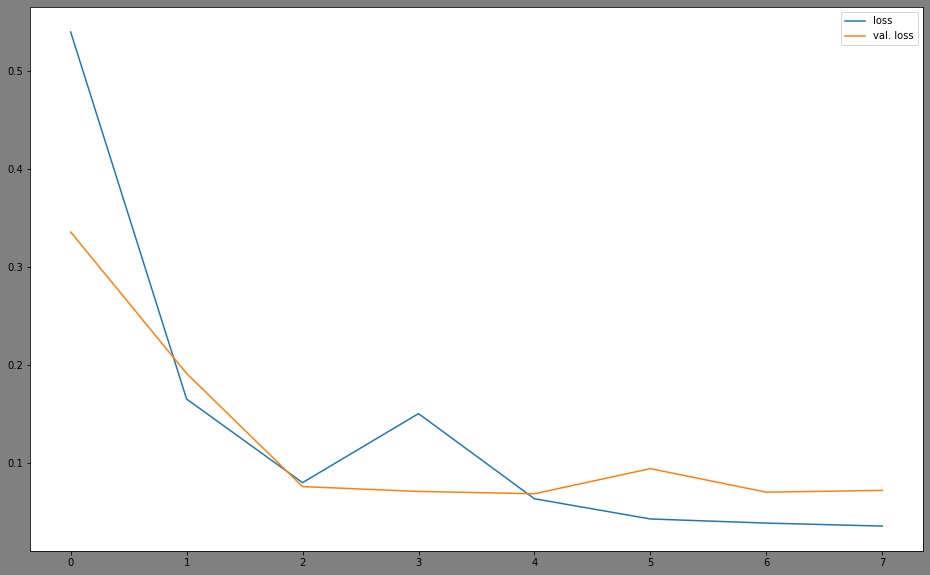

In [28]:
plt.figure(figsize=(16, 10), facecolor='grey')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val. loss')
plt.legend()
plt.show()

In [29]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

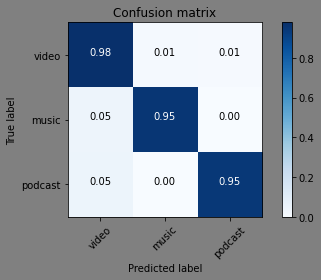

In [30]:
Y_pred = model.predict(test_sequences_matrix)

for i in Y_pred:
  if i[0] > i[1] and i[0] > i[2]:
    i[0] = 1 ; i[1] = 0 ; i[2] = 0
  elif i[1] > i[2]:
    i[0] = 0 ; i[1] = 1 ; i[2] = 0
  else:
    i[0] = 0 ; i[1] = 0 ; i[2] = 1

cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), labels=[0,1,2])
np.set_printoptions(precision=2)

plt.figure(facecolor='grey')
plot_confusion_matrix(cm, classes=['video', 'music', 'podcast'], normalize=True)